In [454]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [455]:
# since we only want 2 classifiers (cow standing or cow laying), this code
# imports the mobilenet model and discards the last 1000 neuron output layer using (include_top=False) 

base_model=MobileNet(weights='imagenet',
                     include_top=False, 
                     input_shape=(128,128,3))  # shape of RGB images 

In [456]:
# Display model layers for the base_model
base_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32) 

In [397]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2,activation='softmax'))


In [457]:
# show the model summary for the tranfer learning model
# note the output has 1024 channels and matches the dimensionality of the Dense layer below
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_14 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_61 (Dense)             (None, 1024)              16778240  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 512)             

In [458]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# pre processing for mobilenet (mobilenet images are normalized from -1 to 1)
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                 shear_range = 0.15,
                                 zoom_range =.15,
                                 rotation_range =5,
                                 fill_mode='nearest')

# use this code for comparision, no augmentatoin
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

# specify the path to the main data folder
file_path = 'C://Users//john.hanks//Documents//Personal//SageMilk//dataset_cows//train//'

# create train_generator iterator object
train_generator=train_datagen.flow_from_directory(file_path, 
                                                 target_size=(128,128),
                                                 color_mode='rgb',
                                                 batch_size= 16,
                                                 seed=1,
                                                 class_mode='categorical',
                                                 shuffle=True)   # set to False to show images in the same order for display



Found 181 images belonging to 2 classes.


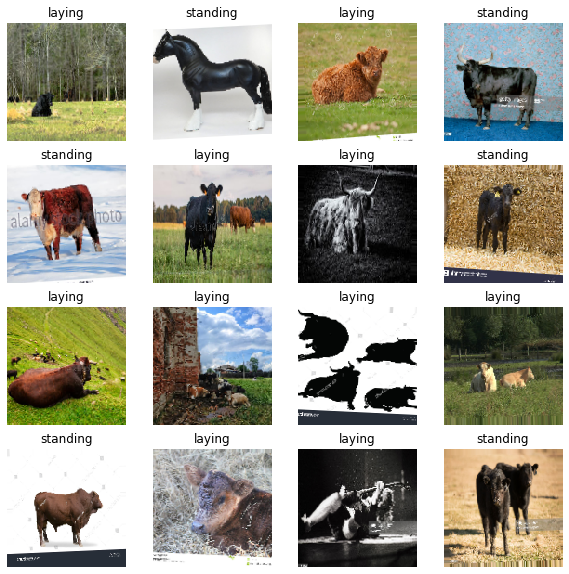

In [460]:
# Data Exploration
import matplotlib.pyplot as plt

x_image,y_label = next(train_generator) # next function gets the next batch of 16 images

fig = plt.figure(figsize=(10, 10))  # set the size of the figures for display
for i in range(x_image.shape[0]):
    plt.subplot(4,4, i + 1)
    plt.axis('off')
    img_out = ((x_image[i]+1)/2)*255  # convert back from imagenet format, imagenet is 0 mean values ranging from -1 to 1
    img_out = img_out.astype(np.uint8)  # convert to unsigned interger 8-bit for display
    plt.imshow(img_out, cmap=plt.cm.gray_r, interpolation='nearest')
    if y_label[i][0] == 1:
        label = "laying"
    else: 
        label = "standing"
    plt.title(label)


In [461]:
# datagenerator keys
train_generator.__dict__.keys()

dict_keys(['image_data_generator', 'target_size', 'color_mode', 'data_format', 'image_shape', 'save_to_dir', 'save_prefix', 'save_format', 'interpolation', 'split', 'subset', 'directory', 'classes', 'class_mode', 'dtype', 'samples', 'num_classes', 'class_indices', 'filenames', '_filepaths', 'n', 'batch_size', 'seed', 'shuffle', 'batch_index', 'total_batches_seen', 'lock', 'index_array', 'index_generator'])

In [462]:
# the class names are taken from the directory names
train_generator.class_indices

{'cow_laying': 0, 'cow_standing': 1}

In [463]:
# n is the number of samples
train_generator.n

181

In [464]:
# Compile and run the model
# Adam optimizer
# loss function will be binary cross entropy
# evaluation metric will be accuracy

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

# automatically set up the step size for each epoc
# only run 5 epocs so training is a short time

# Epoc ==> one pass through all of the training samples
# Batch ==> subset of samples (loading all samples may use too much memory)

step_size_train=train_generator.n//train_generator.batch_size + 1
history = model.fit(train_generator,
          steps_per_epoch=step_size_train,
          epochs=5)

Epoch 1/5
12/12 [==============================] - 13s 1s/step - loss: 0.8079 - accuracy: 0.9171
Epoch 2/5
12/12 [==============================] - 13s 1s/step - loss: 0.2653 - accuracy: 0.9558
Epoch 3/5
12/12 [==============================] - 15s 1s/step - loss: 0.2995 - accuracy: 0.9448
Epoch 4/5
12/12 [==============================] - 14s 1s/step - loss: 0.1003 - accuracy: 0.9337
Epoch 5/5
12/12 [==============================] - 13s 1s/step - loss: 0.1911 - accuracy: 0.9724


In [466]:
# Predict one image at a time
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
image_size = 128

########### Inputs ###################
# change these values to predict the images in a directory
data_set = "test"
behavior = "cow_standing"
mypath = "C:\\Users\\john.hanks\\Documents\\Personal\\SageMilk\\dataset_cows\\"+ data_set + "\\" + behavior + "\\"
class_names = list(train_generator.class_indices.keys())


def convert_to_array(file_path):
    img1 = load_img(file_path, target_size=(image_size, image_size))
    a_img = img_to_array(img1)
    a_img = np.expand_dims(a_img, axis=0)
    return a_img

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

prediction_list = []
i=0
cnt = 0

# keep all the samples in numpy array for plotting 
# X_samples =np.ndarray((train_generator.n,128,128,3)).astype('float32')

for f in onlyfiles:
    input_image = convert_to_array(mypath+f)
    # X_samples[i] = input_image
    
    # images need to be normalized using the same method that imagenet used
    processed_image_mobilenet= preprocess_input(input_image.copy())

    # create a list of predictions for each image in the directory
    prediction_list.append(model.predict(processed_image_mobilenet))  
    if prediction_list[i][0][0] > prediction_list[i][0][1]:
        print(str(mypath+f),class_names[0])
    else:
        print(str(mypath+f),class_names[1])
        cnt +=1
    i+=1
if behavior == class_names[1]:
    print("\n\n" + str(class_names[1]) + "        accuracy = " + str(100*cnt/i))
else:
    print("\n\n" + str(class_names[0]) + "        accuracy = " + str(100 - 100*cnt/i))
print("num of files = " + str(i))

C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\test\cow_standing\Image_1.jpg cow_laying
C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\test\cow_standing\Image_10.jpg cow_standing
C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\test\cow_standing\Image_100.jpg cow_standing
C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\test\cow_standing\Image_11.jpg cow_standing
C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\test\cow_standing\Image_12.jpg cow_standing
C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\test\cow_standing\Image_13.jpg cow_standing
C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\test\cow_standing\Image_14.jpg cow_standing
C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\test\cow_standing\Image_15.jpg cow_laying
C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\test\cow_standing\Image_16.jpg cow_laying
C:\Users\john.hanks\Documents\Personal\SageMilk\dataset_cows\